<a href="https://colab.research.google.com/github/italomarcelogit/python.free/blob/master/COLAB/TENSORFLOW/Classificacao/tensorflow_classifica%C3%A7%C3%A3o_de_texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFQMJUL/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFQMJUL/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFQMJUL/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
len(train_dataset)

25000

In [ ]:
for example, label in train_dataset.take(2):
  print('text: ', example.numpy())
  print('sentiment: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
sentiment:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbi

In [ ]:
# embaralhando os dados
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Set in 2017 (although one might easily mistake it for 1987, judging by the hairstyles and clothing), The Running Man sees all-round good guy Ben Richards (Schwarzeneggar) framed for a crime he didn't commit. After a daring prison break, he is captured and entered as a contestant in the brutal TV game show The Running Man, along with some fellow escapees and the pretty token female, Amber (Maria Conchita Alonso),.<br /><br />Used by the totalitarian government as a way of controlling the masses, the show pits convicts against a range of colourful (and often quite camp) opponents, each having his own unique killing style: Dynamo fires electricity from a special suit, Buzzsaw uses chainsaws, Sub Zero has a razor edged ice hockey stick, and Fireball prefers a flamethrower to finish off contenders. But these killers are no match for Ben Richards, who dispatches each one in a fittingly gruesome manner (followed by the obligatory witticism).<br /><br />Towards the end of the movie,

In [ ]:
# codificador de texto
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))


In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[273,   8,   1, ...,   0,   0,   0],
       [ 10, 208,  11, ...,   0,   0,   0],
       [  4, 353, 317, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()


Original:  b"Set in 2017 (although one might easily mistake it for 1987, judging by the hairstyles and clothing), The Running Man sees all-round good guy Ben Richards (Schwarzeneggar) framed for a crime he didn't commit. After a daring prison break, he is captured and entered as a contestant in the brutal TV game show The Running Man, along with some fellow escapees and the pretty token female, Amber (Maria Conchita Alonso),.<br /><br />Used by the totalitarian government as a way of controlling the masses, the show pits convicts against a range of colourful (and often quite camp) opponents, each having his own unique killing style: Dynamo fires electricity from a special suit, Buzzsaw uses chainsaws, Sub Zero has a razor edged ice hockey stick, and Fireball prefers a flamethrower to finish off contenders. But these killers are no match for Ben Richards, who dispatches each one in a fittingly gruesome manner (followed by the obligatory witticism).<br /><br />Towards the end of the movi

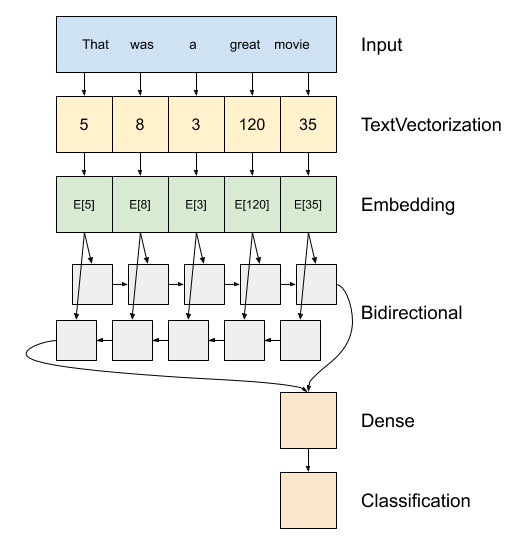

Acima está um diagrama do modelo.

Este modelo pode ser construído como um tf.keras.Sequential.

A primeira camada é o encoder, que converte o texto em uma sequência de índices de token.

Depois que o codificador é uma camada de incorporação. Uma camada de incorporação armazena um vetor por palavra. Quando chamado, ele converte como sequências de índices de palavras em sequências de vetores. Esses vetores são treináveis. Após o treinamento (com dados suficientes), palavras significativas com significados geralmente têm vetores semelhantes.

Essa pesquisa de índice é muito mais eficiente do que uma operação equivalente de passar um vetor codificado um-quente por uma camada tf.keras.layers.Dense.

Uma rede neural recorrente (RNN) processa a entrada de sequência iterando através dos elementos. Os RNNs passam como processo de um passo de tempo para sua entrada no próximo passo de tempo.

O wrapper tf.keras.layers.Bidirectionaltambém pode ser usado com uma camada RNN. Isso propaga a entrada para a frente e para trás através da camada RNN e então concatena a saída final.

A principal vantagem de um RNN bidirecional é que o sinal do início da entrada não precisa ser processado em todos os passos de tempo para afetar a saída.

A principal desvantagem de um RNN bidirecional é que você não pode transmitir a função de forma eficiente enquanto as palavras são adicionadas ao final.

Depois que o RNN converteu a sequência em um único vetor, as duas layers.Dense. layers.Densefazem algum processamento final e convertem essa representação vetorial em um único logit como a saída de classificação.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00174009]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])


[0.00174009]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Treinando o modelo

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 696s 2s/step - loss: 0.6819 - accuracy: 0.5118 - val_loss: 0.5132 - val_accuracy: 0.6984
Epoch 2/10
391/391 [==============================] - 679s 2s/step - loss: 0.4602 - accuracy: 0.7604 - val_loss: 0.4213 - val_accuracy: 0.8292
Epoch 3/10
391/391 [==============================] - 680s 2s/step - loss: 0.3759 - accuracy: 0.8368 - val_loss: 0.3567 - val_accuracy: 0.8453
Epoch 4/10
391/391 [==============================] - 676s 2s/step - loss: 0.3419 - accuracy: 0.8497 - val_loss: 0.3391 - val_accuracy: 0.8505
Epoch 5/10
391/391 [==============================] - 683s 2s/step - loss: 0.3256 - accuracy: 0.8604 - val_loss: 0.3328 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 686s 2s/step - loss: 0.3129 - accuracy: 0.8692 - val_loss: 0.3334 - val_accuracy: 0.8479
Epoch 7/10
391/391 [==============================] - 685s 2s/step - loss: 0.3138 - accuracy: 0.8652 - val_loss: 0.3313 - val_accuracy: 0.8609

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 136s 347ms/step - loss: 0.3149 - accuracy: 0.8612
Test Loss: 0.31493547558784485
Test Accuracy: 0.8611999750137329


(0.0, 0.6563993483781815)

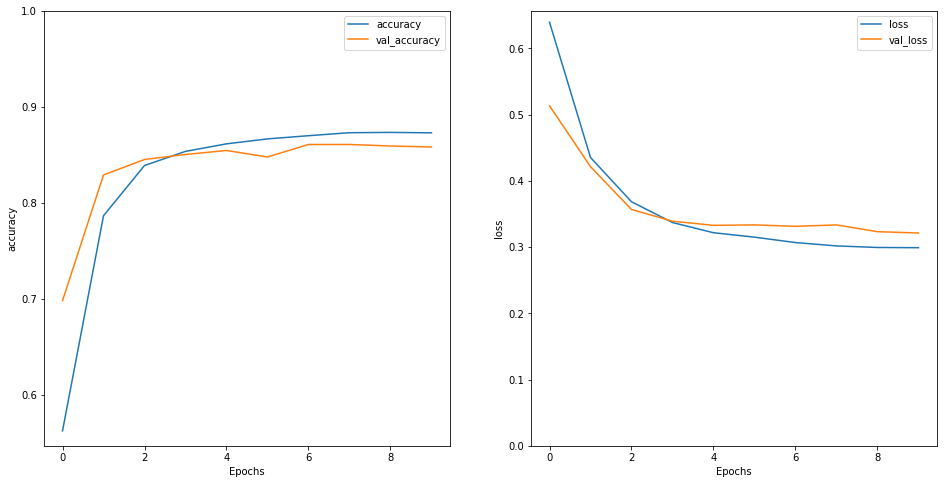

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

# Treinando outro modelo com 3 camadas

In [ ]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1250s 3s/step - loss: 0.6807 - accuracy: 0.5146 - val_loss: 0.4355 - val_accuracy: 0.7875
Epoch 2/10
391/391 [==============================] - 1219s 3s/step - loss: 0.4075 - accuracy: 0.8222 - val_loss: 0.3639 - val_accuracy: 0.8276
Epoch 3/10
391/391 [==============================] - 1229s 3s/step - loss: 0.3488 - accuracy: 0.8496 - val_loss: 0.3416 - val_accuracy: 0.8349
Epoch 4/10
391/391 [==============================] - 1234s 3s/step - loss: 0.3253 - accuracy: 0.8619 - val_loss: 0.3253 - val_accuracy: 0.8474
Epoch 5/10
391/391 [==============================] - 1222s 3s/step - loss: 0.3073 - accuracy: 0.8696 - val_loss: 0.3298 - val_accuracy: 0.8401
Epoch 6/10
391/391 [==============================] - 1232s 3s/step - loss: 0.3072 - accuracy: 0.8687 - val_loss: 0.3300 - val_accuracy: 0.8505
Epoch 7/10
391/391 [==============================] - 1232s 3s/step - loss: 0.3102 - accuracy: 0.8680 - val_loss: 0.3190 - val_accuracy:

In [ ]:
test_loss2, test_acc2 = model2.evaluate(test_dataset)

print('Test Loss 2: {}'.format(test_loss2))
print('Test Accuracy 2: {}'.format(test_acc2))

391/391 [==============================] - 254s 650ms/step - loss: 0.3188 - accuracy: 0.8602
Test Loss 2: 0.31876882910728455
Test Accuracy 2: 0.8602399826049805


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions2 = model2.predict(np.array([sample_text]))
print(predictions2)

[[-1.966146]]


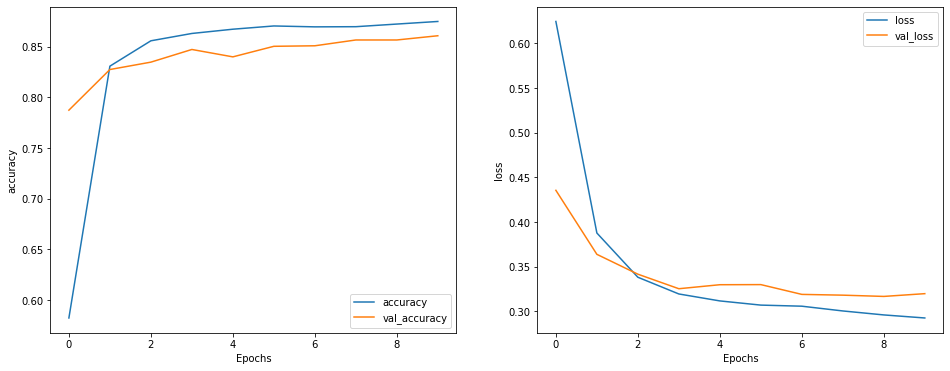

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history2, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history2, 'loss')

In [ ]:
model.save('model2D.tf')

INFO:tensorflow:Assets written to: model2D.tf/assets


INFO:tensorflow:Assets written to: model2D.tf/assets


In [ ]:
model2.save('model3D.tf')

INFO:tensorflow:Assets written to: model3D.tf/assets


INFO:tensorflow:Assets written to: model3D.tf/assets
